<a href="https://colab.research.google.com/github/atharva0300/BE-8th-Semester/blob/main/nlp_mini_project/text_summarization_with_simple_transformers_t5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text summarization with Simple Transformers T5

In [106]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
import os
os.environ['LC_ALL'] = 'C.UTF-8'
os.environ['LANG'] = 'C.UTF-8'

In [108]:
import locale
print(locale.getpreferredencoding())

UTF-8


In [109]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [110]:
!LC_ALL=C.UTF-8 LANG=C.UTF-8 pip install -q sumeval==0.2.2
!pip install -q nlpaug==1.1.3
!pip install -q simpletransformers==0.60.9

In [111]:
! pip install -q nltk==3.5

## Import libraries <a class="anchor" id="Import-libraries"></a>

In [112]:
import gc
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

import nlpaug.augmenter.word as naw
from sumeval.metrics.rouge import RougeCalculator

import torch
from simpletransformers.t5 import T5Model, T5Args

print('Pytorch version: %s'  % torch.__version__)

Pytorch version: 2.2.1+cu121


In [113]:
warnings.simplefilter('ignore')
pd.set_option('display.max_colwidth', 10000)
cuda =  torch.cuda.is_available()

In [114]:
pip install datasets -q

In [115]:
from datasets import load_dataset

dataset = load_dataset("iqballx/indonesian_news_datasets" , split = 'train')
df = dataset.to_pandas()
df.dropna().reset_index(drop=True)

id    source  \
0         83     tempo   
1         84     tempo   
2         85     tempo   
3         86     tempo   
4         87     tempo   
...      ...       ...   
32122  63563  kumparan   
32123  63564  kumparan   
32124  63565  kumparan   
32125  63566  kumparan   
32126  63567     tempo   

                                                                                        title  \
0      Depo Plumpang Terbakar, Anggota DPR Minta Pertamina Pastikan Pasokan BBM Tak Terganggu   
1                 Jokowi Perintahkan Wapres Ma'ruf Amin Tinjau Lokasi Kebakaran Depo Plumpang   
2                                     HNW Mendukung Jamaah Umroh First Travel Dapatkan Haknya   
3             Tim Dokkes Polri Telah Terima 14 Kantong Jenazah Korban Kebakaran Depo Plumpang   
4                            Bamsoet Ajak Komunitas Otomotif Kembangkan Perekonomian Nasional   
...                                                                                       ...   
32122              5 Hewan Aneh yang Hidup di Palung Mariana, Salah Satu Tempat Terdalam Bumi   
32123                    Biadab! Guru SD di Banyuwangi Cabuli Siswinya, Polisi Tangkap Pelaku   
32124                       Aji Santoso: Jakmania Perlakukan Persebaya dengan Baik di Jakarta   
32125         Sopir Audi Cium Kaki Ibu & Istri Hamil Usai Sidang: Semoga Kebenaran Ditegakkan   
32126                                               Ini Besaran Biaya Haji 2023 per Embarkasi   

                                                                                                                                                                                image  \
0                                                                                                                  https://statik.tempo.co/data/2023/03/04/id_1186060/1186060_720.jpg   
1                                                                                                                  https://statik.tempo.co/data/2023/03/04/id_1186059/1186059_720.jpg   
2                                                                                                                  https://statik.tempo.co/data/2023/03/04/id_1186020/1186020_720.jpg   
3                                                                                                                  https://statik.tempo.co/data/2023/03/04/id_1186056/1186056_720.jpg   
4                                                                                                                  https://statik.tempo.co/data/2023/03/04/id_1186051/1186051_720.jpg   
...                                                                                                                                                                               ...   
32122                                        https://blue.kumparan.com/image/upload/fl_progressive,fl_lossy,c_fill,q_auto:best,w_480,f_jpg/v1634025439/01gxq9nxymgrqywgfwayr1pvzf.png   
32123                                        https://blue.kumparan.com/image/upload/fl_progressive,fl_lossy,c_fill,q_auto:best,w_480,f_jpg/v1634025439/01gbzcq57rybektgvhztkn3h0c.jpg   
32124  https://blue.kumparan.com/image/upload/fl_progressive,fl_lossy,c_fill,q_auto:best,w_480,f_jpg/v1634025439/82a9dba56b3d9db68c51f5b6a286f1c8561f94097038ce283ceff9aefae69af3.jpg   
32125                                        https://blue.kumparan.com/image/upload/fl_progressive,fl_lossy,c_fill,q_auto:best,w_480,f_jpg/v1634025439/01gxrhmfq7f8b0b19er3fae5eg.jpg   
32126                                                                                                              https://statik.tempo.co/data/2022/07/17/id_1125794/1125794_720.jpg   

                                                                                                                                  url  \
0        https://nasional.tempo.co/read/1698528/depo-plumpang-terbakar-anggota-dpr-minta-pertamina-pastikan-pasokan-bbm-tak-terganggu   
1                   https://nasional.

In [116]:
df.shape

(32735, 11)

In [117]:
# drop the columns in summary series with the type none
# Drop None values from the 'summary' column
df = df.dropna(subset=['summary'])

# Reset the index
df = df.reset_index(drop=True)

In [118]:
# drop the columns in summary series with the type none
# Drop None values from the 'summary' column
df = df.dropna(subset=['content'])

# Reset the index
df = df.reset_index(drop=True)

In [119]:
df.shape

(32284, 11)

In [120]:
# df = pd.read_csv('/content/drive/MyDrive/nlp_dataset/news_dataset_2.csv', encoding='ISO-8859-1').dropna().reset_index(drop=True)

## EDA <a class="anchor" id="EDA"></a>

In [121]:
display(df.head(1))

id source  \
0  83  tempo   

                                                                                    title  \
0  Depo Plumpang Terbakar, Anggota DPR Minta Pertamina Pastikan Pasokan BBM Tak Terganggu   

                                                                image  \
0  https://statik.tempo.co/data/2023/03/04/id_1186060/1186060_720.jpg   

                                                                                                                            url  \
0  https://nasional.tempo.co/read/1698528/depo-plumpang-terbakar-anggota-dpr-minta-pertamina-pastikan-pasokan-bbm-tak-terganggu   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          content  \
0  TEMPO.CO, Jakarta - Anggota Komisi VII DPR RI Rofik Hananto menyayangkan terjadinya insiden kebakaran yang disebabkan oleh bocornya depo Plumpang, Jakarta Utara, pada Jumat, 3 Maret 2023."Turut berbela sungkawa terhadap masyarakat sipil yang terdampak, apalagi ini daerah padat penduduk. Pertamina harus tanggung jawab," kata dia dalam keterangan di Jakarta Sabtu, 4 Maret 2024.Rofik mengatakan Pertamina serta pihak terkait harus memastikan keselamatan dan keamanan warga yang tinggal di sekitar lokasi.Pipa BBM yang terbakar itu merupakan bagian dari Terminal Bahan Bakar Minyak (TBBM) Plumpang. TBBM Plumpang dinilai sebagai salah satu terminal BBM terpenting di Indonesia, sehingga Rofik juga menegaskan Pertamina harus memastikan pasokan bahan bakar minyak tetap aman meski ada insiden tersebut."Plumpang menyuplai sekitar 20 persen kebutuhan BBM harian di Indonesia, atau sekitar 25 persen dari total kebutuhan SPBU Pertamina. Maka tindakan selanjutnya adalah bagaimana memastikan suplai BBM tidak terganggu," katanya.Rofik juga menyinggung kejadian kilang minyak milik Pertamina yang sebelumnya pernah terjadi kejadian serupa, seperti Kilang Balikpapan pada Maret 2022 lalu. Terhitung 2 tahun terakhir ini, kata dia, sudah 5 fasilitas migas milik

In [122]:
df['content_length'] = [len(df['content'][i]) for i in range(len(df))]
df['summary_length'] = [len(df['summary'][i]) for i in range(len(df))]

In [123]:
print('df content length:\n', df['content_length'].describe())
print('df summary length:\n', df['summary_length'].describe())

df content length:
 count    32284.000000
mean      2297.652243
std       1191.080461
min         79.000000
25%       1536.000000
50%       2086.000000
75%       2789.000000
max      13833.000000
Name: content_length, dtype: float64
df summary length:
 count    32284.000000
mean       446.718251
std        110.871748
min         74.000000
25%        370.750000
50%        452.000000
75%        526.000000
max        985.000000
Name: summary_length, dtype: float64


In [124]:
display(df.head(1))

id source  \
0  83  tempo   

                                                                                    title  \
0  Depo Plumpang Terbakar, Anggota DPR Minta Pertamina Pastikan Pasokan BBM Tak Terganggu   

                                                                image  \
0  https://statik.tempo.co/data/2023/03/04/id_1186060/1186060_720.jpg   

                                                                                                                            url  \
0  https://nasional.tempo.co/read/1698528/depo-plumpang-terbakar-anggota-dpr-minta-pertamina-pastikan-pasokan-bbm-tak-terganggu   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          content  \
0  TEMPO.CO, Jakarta - Anggota Komisi VII DPR RI Rofik Hananto menyayangkan terjadinya insiden kebakaran yang disebabkan oleh bocornya depo Plumpang, Jakarta Utara, pada Jumat, 3 Maret 2023."Turut berbela sungkawa terhadap masyarakat sipil yang terdampak, apalagi ini daerah padat penduduk. Pertamina harus tanggung jawab," kata dia dalam keterangan di Jakarta Sabtu, 4 Maret 2024.Rofik mengatakan Pertamina serta pihak terkait harus memastikan keselamatan dan keamanan warga yang tinggal di sekitar lokasi.Pipa BBM yang terbakar itu merupakan bagian dari Terminal Bahan Bakar Minyak (TBBM) Plumpang. TBBM Plumpang dinilai sebagai salah satu terminal BBM terpenting di Indonesia, sehingga Rofik juga menegaskan Pertamina harus memastikan pasokan bahan bakar minyak tetap aman meski ada insiden tersebut."Plumpang menyuplai sekitar 20 persen kebutuhan BBM harian di Indonesia, atau sekitar 25 persen dari total kebutuhan SPBU Pertamina. Maka tindakan selanjutnya adalah bagaimana memastikan suplai BBM tidak terganggu," katanya.Rofik juga menyinggung kejadian kilang minyak milik Pertamina yang sebelumnya pernah terjadi kejadian serupa, seperti Kilang Balikpapan pada Maret 2022 lalu. Terhitung 2 tahun terakhir ini, kata dia, sudah 5 fasilitas migas milik

In [125]:
df.columns

Index(['id', 'source', 'title', 'image', 'url', 'content', 'date', 'embedding',
       'created_at', 'updated_at', 'summary', 'content_length',
       'summary_length'],
      dtype='object')

In [126]:
df = df.drop(['id' , 'source' , 'title' , 'image',  'url' , 'date' , 'content_length' , 'summary_length' , 'embedding' , 'created_at' , 'updated_at'], axis=1)
df = df.reset_index(drop=True)

In [127]:
df.columns

Index(['content', 'summary'], dtype='object')

In [128]:
# Split the content column into batches (e.g., 5000 rows per batch)
batch_size = 100
num_batches = len(df) // batch_size + 1
batches = [df['content'].iloc[i*batch_size:(i+1)*batch_size] for i in range(num_batches)]

# Initialize an empty dictionary to store word counts
all_words_counts = {}

# Iterate over each batch and compute value_counts
for i, batch in enumerate(batches):
    batch_counts = batch.str.split(expand=True).unstack().value_counts()
    for word, count in batch_counts.items():
        all_words_counts[word] = all_words_counts.get(word, 0) + count

# Convert the dictionary to a DataFrame
all_words_df = pd.DataFrame(list(all_words_counts.items()), columns=['Word', 'Count'])

# Sort the DataFrame by count in descending order
all_words_df = all_words_df.sort_values(by='Count', ascending=False)

# Select the top 50 words
top_words_df = all_words_df.head(50)

# Plot the top 50 word frequencies
import plotly.graph_objs as go

data = [go.Bar(
            x = top_words_df['Word'],
            y = top_words_df['Count'],
            marker= dict(colorscale='Jet',
                         color = top_words_df['Count']
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 Word frequencies in the dataset'
)

fig = go.Figure(data=data, layout=layout)

fig.show()

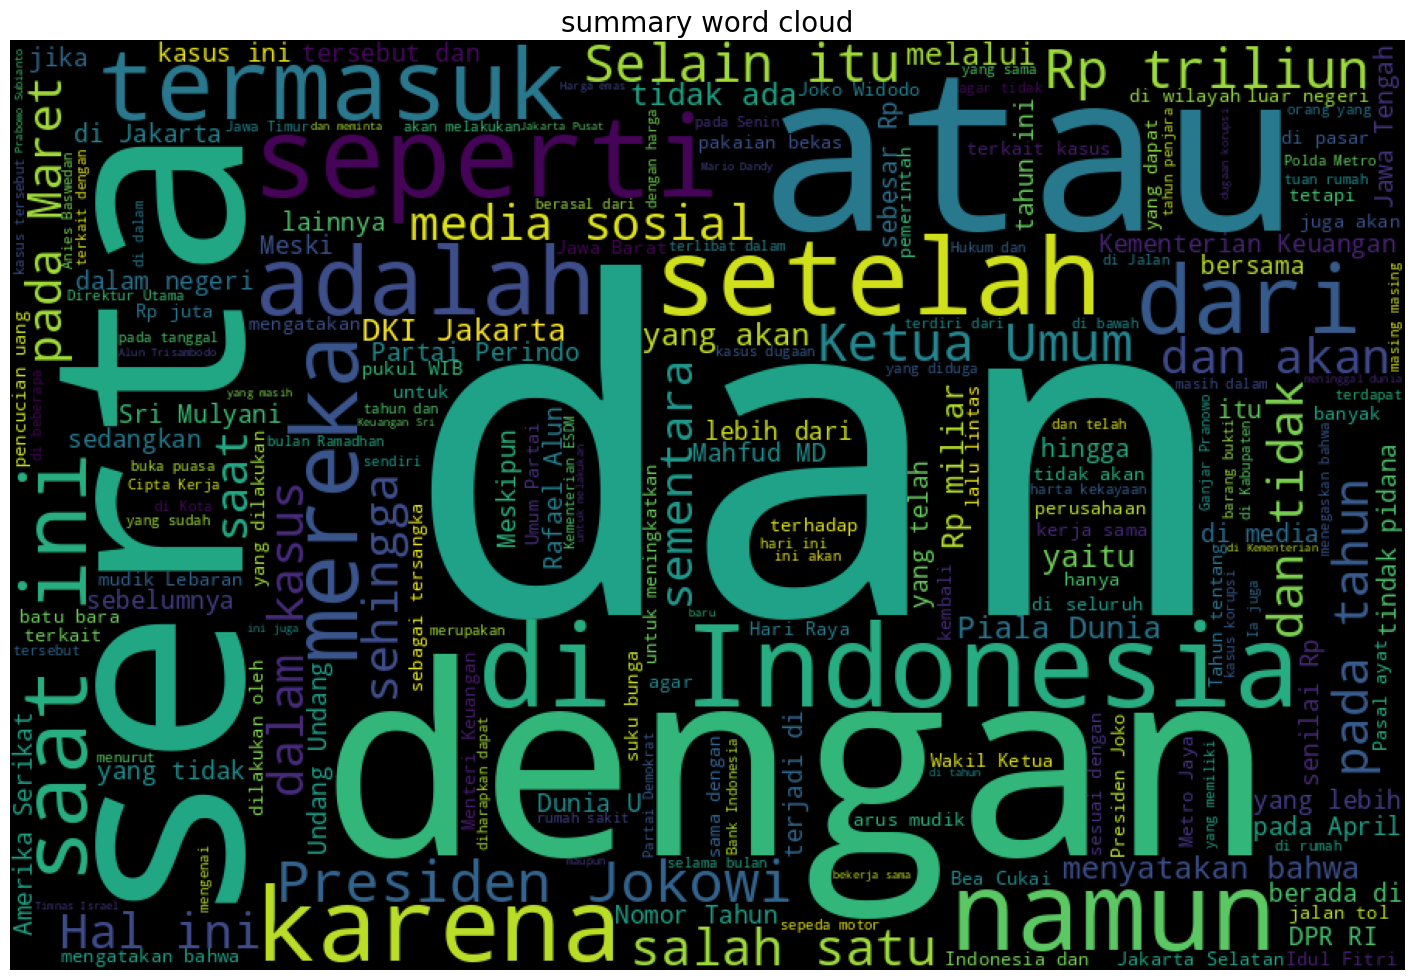

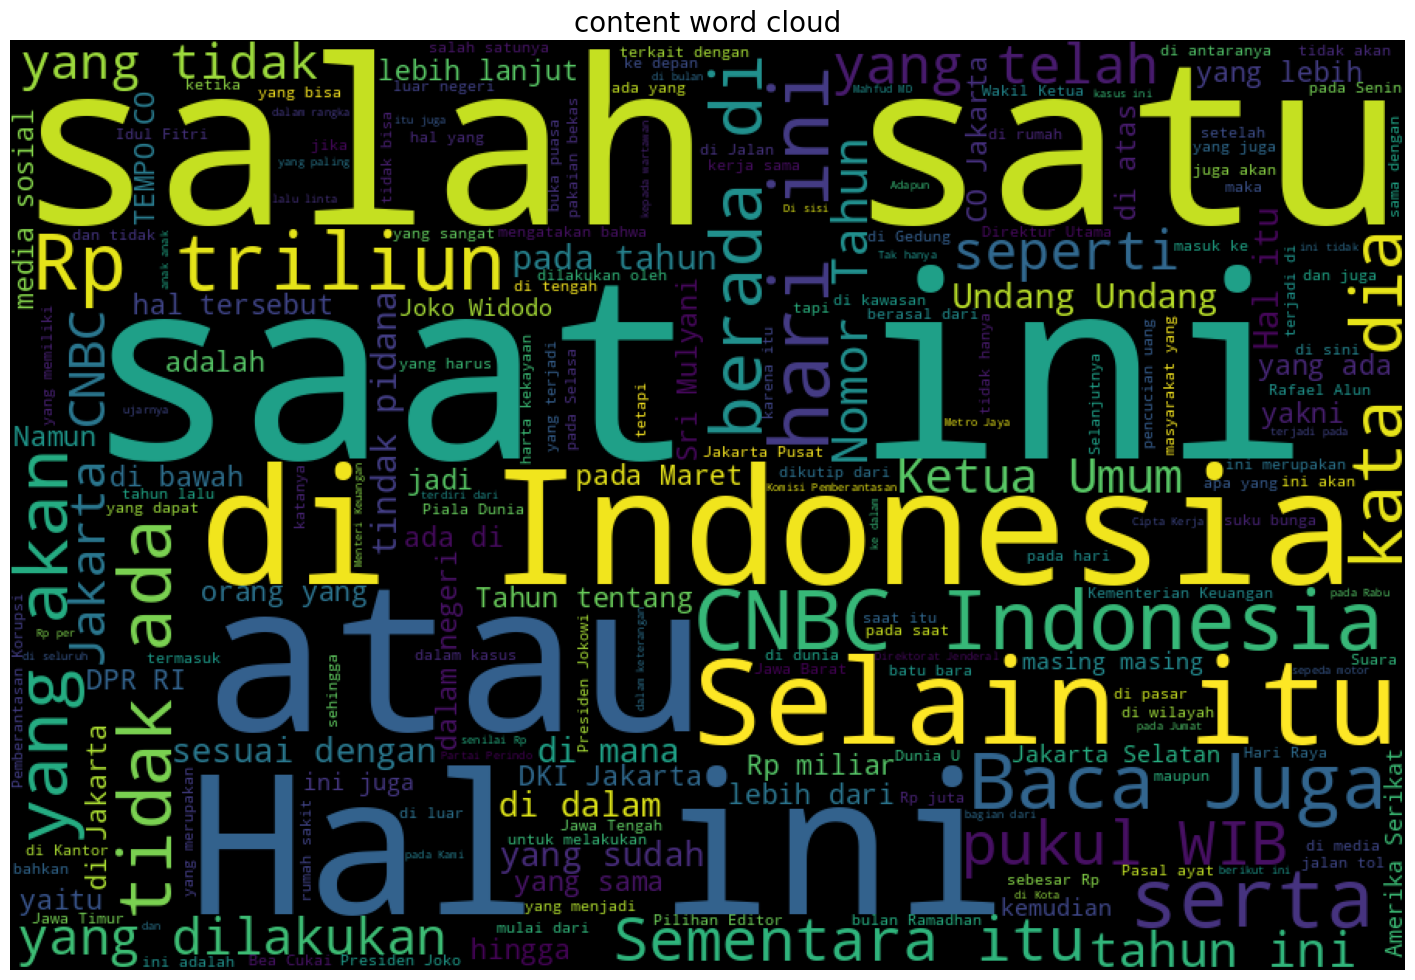

In [129]:
wc = WordCloud(width=900, height=600)

wc.generate(','.join(df['summary']))
plt.figure(figsize=(18,13))
plt.imshow(wc)
plt.axis('off')
plt.title('summary word cloud', fontdict={'fontsize': 20})

wc.generate(','.join(df['content']))
plt.figure(figsize=(18,13))
plt.imshow(wc)
plt.axis('off')
plt.title('content word cloud', fontdict={'fontsize': 20})

plt.show()

In [130]:
df = df.rename(columns={'content': 'input_text', 'summary': 'target_text'}).reindex(columns=['input_text', 'target_text'])
df['prefix'] = ''

train, test = train_test_split(df, test_size=0.2, random_state=42)
train, valid = train_test_split(train, test_size=0.2, random_state=42)

After applying data augmentation, we will combine them with the original train data.

In [132]:
train.head(2)

,input_text,target_text,prefix
26268,"JAKARTA - Humor Gus Dur menjadi hiburan tersendiri bagi banyak orang. Gus Dur atau Abdurrahman Wahid kerap melontarkan guyonannya saat tampil. Ada sebuah kisah humor yang pernah dia ceritakan mengenai orang Jawa dan Sunda yang bertemu. ""Orang sunda di Stasiun Cirebon lama nunggu di depan WC, atau kakus,"" cerita Gus Dur, dikutip dari Youtube Maarif NU Jateng. Lalu, pintu WC itu akhirnya dibuka. Orangnya keluar dari dalam toilet tersebut sembari merapihkan celana. ""Atos?"" tanya si orang Sunda. Gus Dur menjelaskan, orang Sunda kan bahasanya halus. Di mana atos yang dimaksud itu berarti ""sudah"". Tetapi, si orang Jawa itu malah salah paham. ""Atos atos, orang mencret kok!"" cerita Gus Dur sambil tertawa terbahak-bahak. Baca Juga: 5 Tips Mengatasi Kulit Kusam, agar Terlihat Lebih Sehat (dka)","Gus Dur mengenang kembali humor nya mengenai orang Jawa dan Sunda yang bertemu di stasiun Cirebon. Orang Sunda menanyakan ""Atos?"" yang berarti sudah, namun orang Jawa salah paham dan tertawa.",
29092,"JAKARTA - PT Trimegah Karya Pratama Tbk (UVCR) atau Ultra Voucher mencatatkan laba bersih Rp11,88 miliar atau naik 113,30% dari sebelumnya sebesar Rp5,57 miliar. Di samping itu, angka penjualan perseroan juga naik 30,12% menjadi Rp1,22 triliun, dari sebelumnya sebesar Rp939,20 miliar. Kenaikan penjualan UVCR ditopang oleh penjualan voucher digital dan fisik sebesar Rp1,2 triliun baik di aplikasi Ultra Voucher, B2B dan e-commerce. Kemudian, sebesar Rp1,9 miliar dikontribusikan oleh transaksi biller, serta sebesar Rp1,6 miliar berasal dari pendapatan lainnya. Direktur Utama UVCR Hady Kuswanto menyampaikan, pertumbuhan kinerja perseroan didasari oleh sinergi dan ekspansi bisnis yang dilakukan. Adapun, sinergi dan ekspansi bisnis tersebut dilakukan tidak hanya berdasarkan wilayah, namun juga terhadap teknologi yang digunakan di seluruh lini produk dan jasa perseroan sehingga menghasilkan solusi yang dapat diaplikasikan oleh seluruh pihak. Pencapaian kinerja tahun 2022 didukung oleh adaptasi cepat kami dalam melihat momentum masyarakat, untuk menggunakan voucher sebagai sarana pemenuhan kebutuhan masyarakat, kata Hady dalam keterangan resminya, Kamis (6/4/2023). Hady menjelaskan, adaptasi yang dilakukan oleh perseroan tidak terbatas hanya kepada individu, melainkan secara universal. Di mana, solusi perseroan dapat mendukung pertumbuhan dari berbagai perusahaan terhadap kebutuhan voucher, katalog, hingga loyalti. Menurut dia, solusi yang diberikan UVCR sebagai perusahaan teknologi bersifat universal. Pasalnya, produk dan jasa perseroan dapat digunakan langsung oleh pengguna melalui aplikasi, e-commerce, dan gift card. Kami juga memiliki corporate solution untuk membantu perusahaan lainnya bertumbuh dan memiliki fitur voucher, katalog dan loyalty engine, imbuh dia. Baca Juga: 7 Vila Murah di Ubud untuk Refreshing Bareng Keluarga Lebih lanjut, sejalan dengan tujuan pemerintah Indonesia dalam melakukan adaptasi teknologi kepada setiap perusahaan, UVCR akan terus berinovasi untuk menciptakan valuable added solutions and services yang dapat digunakan oleh seluruh pihak agar dapat bertumbuh bersama. Adapun, di tahun 2023 ini perseroan menargetkan pendapatan sebesar Rp1,8 triliun. Untuk mencapai target tersebut, UVCR akan memperkuat sinergi, melakukan ekspansi bisnis yang terukur, dan penguatan di seluruh lini solusi perseroan.","Ultra Voucher mencatatkan laba bersih sebesar Rp11,88 miliar atau naik 113,30% dari tahun sebelumnya dengan penjualan naik 30,12% menjadi Rp1,22 triliun, didukung oleh penjualan voucher digital dan fisik. Direktur Utama mengatakan kalau kinerja perseroan didasari oleh sinergi dan ekspansi bisnis yang dilakukan, termasuk melalui teknologi yang digunakan di seluruh lini produk dan jasa perseroan. Pada tahun ini, perseroan menargetkan pendapatan sebesar Rp1,8 triliun.",


In [133]:
pip show nltk

Name: nltk
Version: 3.5
Summary: Natural Language Toolkit
Home-page: http://nltk.org/
Author: Steven Bird
Author-email: stevenbird1@gmail.com
License: Apache License, Version 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: click, joblib, regex, tqdm
Required-by: textblob


In [134]:
import nltk

In [144]:
def random_insertion(text, n=3):
    words = text.split()
    for _ in range(n):
        idx = random.randint(0, len(words) - 1)
        words.insert(idx, random.choice(words))
    return ' '.join(words)

train = pd.concat([
    train,
    pd.DataFrame({'input_text': train['input_text'].apply(random_insertion),
                  'target_text': list(train['target_text']),
                  'prefix': ''}),
])

In [145]:
train.head(1)

,input_text,target_text,prefix
26268,"JAKARTA - Humor Gus Dur menjadi hiburan tersendiri bagi banyak orang. Gus Dur atau Abdurrahman Wahid kerap melontarkan guyonannya saat tampil. Ada sebuah kisah humor yang pernah dia ceritakan mengenai orang Jawa dan Sunda yang bertemu. ""Orang sunda di Stasiun Cirebon lama nunggu di depan WC, atau kakus,"" cerita Gus Dur, dikutip dari Youtube Maarif NU Jateng. Lalu, pintu WC itu akhirnya dibuka. Orangnya keluar dari dalam toilet tersebut sembari merapihkan celana. ""Atos?"" tanya si orang Sunda. Gus Dur menjelaskan, orang Sunda kan bahasanya halus. Di mana atos yang dimaksud itu berarti ""sudah"". Tetapi, si orang Jawa itu malah salah paham. ""Atos atos, orang mencret kok!"" cerita Gus Dur sambil tertawa terbahak-bahak. Baca Juga: 5 Tips Mengatasi Kulit Kusam, agar Terlihat Lebih Sehat (dka)","Gus Dur mengenang kembali humor nya mengenai orang Jawa dan Sunda yang bertemu di stasiun Cirebon. Orang Sunda menanyakan ""Atos?"" yang berarti sudah, namun orang Jawa salah paham dan tertawa.",


### Training

In [147]:
train_params = {
    'max_seq_length': 512,
    'max_length': 128,
    'train_batch_size': 8,
    'eval_batch_size': 8,
    'num_train_epochs': 1,
    'evaluate_during_training': True,
    'evaluate_during_training_steps': 10000,
    'use_multiprocessing': False,
    'fp16': True,
    'save_steps': -1,
    'save_eval_checkpoints': False,
    'save_model_every_epoch': False,
    'no_cache': True,
    'reprocess_input_data': True,
    'overwrite_output_dir': True,
    'preprocess_inputs': False,
    'num_return_sequences': 1
}

model = T5Model('t5', 't5-small', args=train_params, use_cuda=True)
model.train_model(train, eval_data=valid)
gc.collect()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/41322 [00:00<?, ?it/s]

Using Adafactor for T5


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/5166 [00:00<?, ?it/s]

  0%|          | 0/5166 [00:00<?, ?it/s]

212293

### Predict

In [148]:
pred_params = {
        'max_seq_length': 512,
        'use_multiprocessed_decoding': False
        }

model = T5Model('t5', 'outputs/best_model', args=pred_params, use_cuda=True)
pred = model.predict(list(test['input_text']))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Generating outputs:   0%|          | 0/808 [00:00<?, ?it/s]

In [149]:
random.sample(pred, 5)

['Kemenaker telah menerbitkan Surat Edaran Nomor M/2/HK.04.00/III/2023 tentang Pelaksanaan Pemberian Tunjangan Hari Raya Keagamaan Tahun 2023 bagi Pekerja/Buruh di Perusahaan.',
 'Panglima TNI Laksamana Yudo Margono mengupayakan langkah persuasif untuk menyelamatkan pilot Susi Air, Kapten Philips Mark Marthens yang disandera kelompok kriminal bersenjata (KKB). Yudo tak ingin menempuh cara militer karena dapat membahayakan nyawa sang pilot dan masyarakat. TNI j',
 'Kementerian Sekretariat Negara mengklaim Tim Verifikasi dan Validasi Harta Kekayaan Aparatur Sipil Negara yang telah menelisik kewajaran harta kekayaan Esha Rahmanshah Abrar. Kepala Subbagian Administrasi Kendaraan Biro Umum di Setneg menyatakan tim sudah mengantongi transaksi keuangan ber',
 'HR, seorang pelaku pembunuhan juru parkir berinisial SRS (43) di Pasar Tasik, Jakarta Pusat sempat bersembunyi di rumah keluarganya di Kawasan Cengkareng, Jakarta Barat. HR hanya bisa menunduk saat digelandang polisi ketika tiba di Polr

# Using Sumval for evaluation metrics

In [150]:
rouge = RougeCalculator(stopwords=True, lang="id")

def rouge_calc(preds, targets):
    rouge_1 = [rouge.rouge_n(summary=preds[i],references=targets[i],n=1) for i in range(len(preds))]
    rouge_2 = [rouge.rouge_n(summary=preds[i],references=targets[i],n=2) for i in range(len(preds))]
    rouge_l = [rouge.rouge_l(summary=preds[i],references=targets[i]) for i in range(len(preds))]

    return {"Rouge_1": np.array(rouge_1).mean(),
            "Rouge_2": np.array(rouge_2).mean(),
            "Rouge_L": np.array(rouge_l).mean()}

In [151]:
rouge_calc(pred, list(test['target_text']))

{'Rouge_1': 0.4164891561605098,
 'Rouge_2': 0.23658778233939057,
 'Rouge_L': 0.3365173464858615}